# 3 - Pool Volume Analysis
In this section, we focus on the pools' 24H volume trend. Both time and frequency domain techniques will be used. Hourly volume analysis may be added in the future.

In [1]:
# Standard Library
import math
import os

# Third Party Library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.pyplot import MaxNLocator

# Local Folder Library
from pyammanalysis.util import *

In [2]:
# read df from csv
pools_df = pd.read_csv(os.path.join(DATA_PATH, "pools_df.csv"))
pool_names = pools_df["name"]

pool_day_df = pd.read_csv(
    os.path.join(DATA_PATH, "pool_day_df.csv"), parse_dates=["date"]
)

subplots_per_col = math.ceil(len(pool_names) / SUBPLOTS_PER_ROW)

## Time Domain
### Time Trend

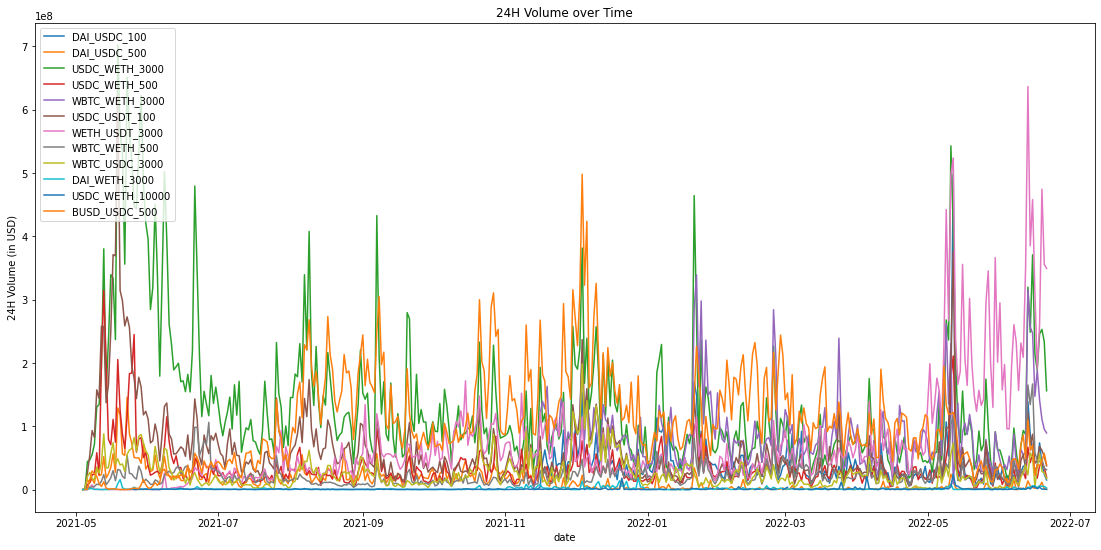

In [3]:
plt.figure(figsize=(19, 9))
for pool_name in pool_names:
    try:
        plt.plot(pool_day_df["date"], pool_day_df[pool_name + "_volumeUSD"])
    except:
        continue
plt.title("24H Volume over Time")
plt.xlabel("date")
plt.ylabel("24H Volume (in USD)")
plt.legend(pool_names, loc="upper left")
plt.show()

### Histogram
Observe the distribution of the prices.

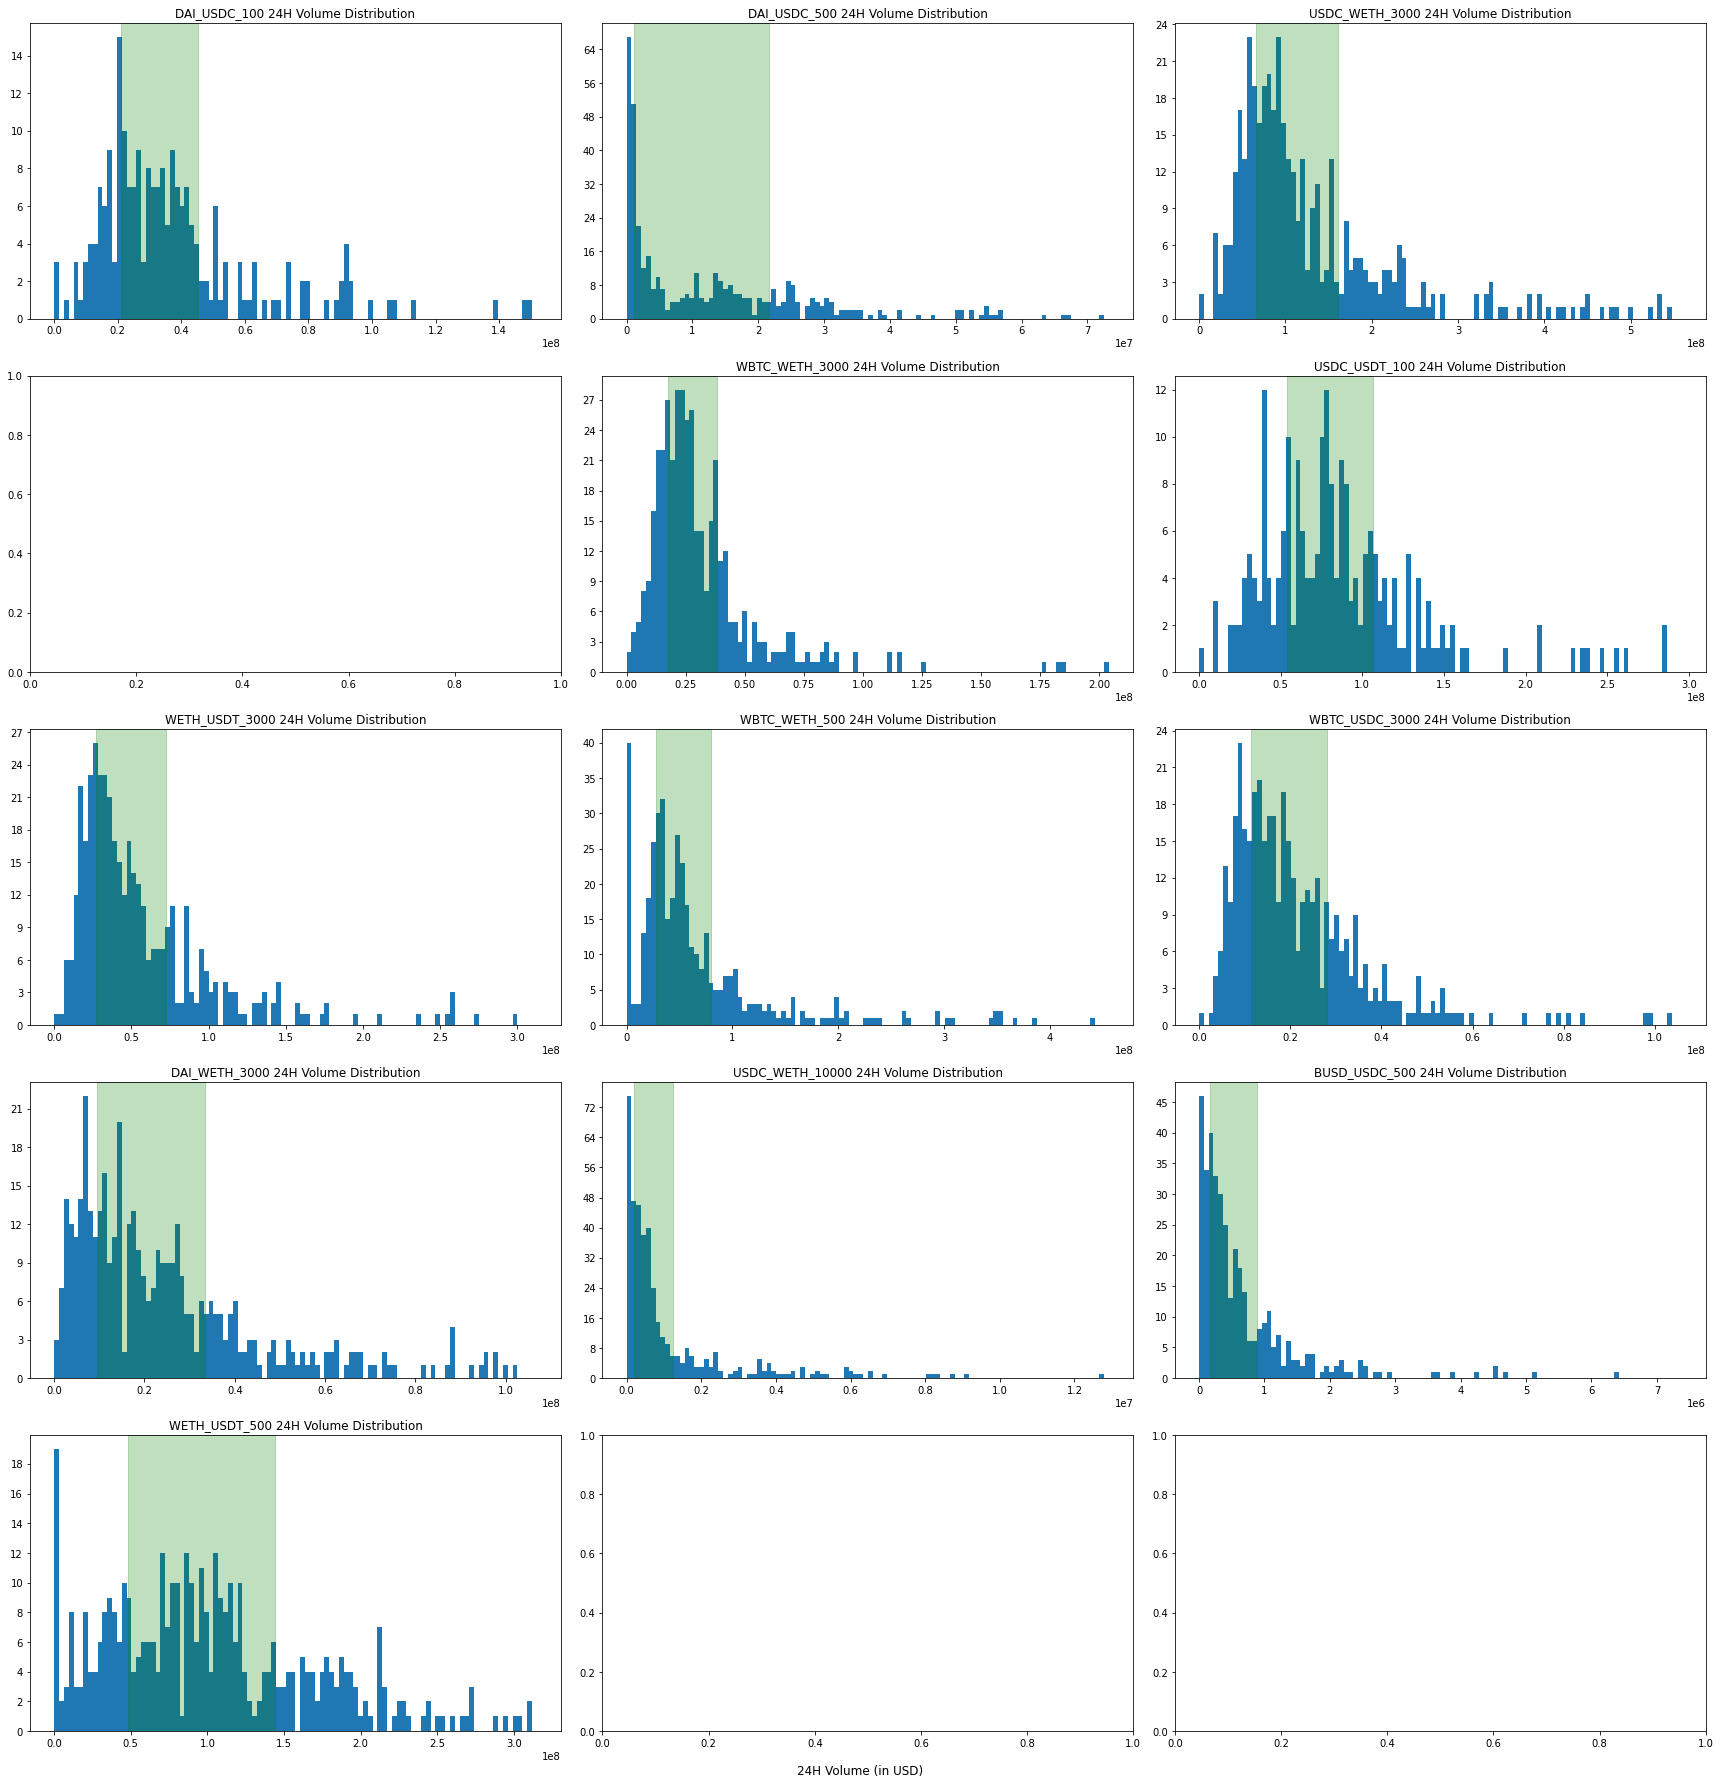

In [4]:
fig = plt.figure(figsize=(PLOT_WIDTH, SUBPLOT_HEIGHT * subplots_per_col))
axes = fig.subplots(subplots_per_col, SUBPLOTS_PER_ROW)

for i, pool_name in enumerate(pool_names):
    try:
        volumeUSD_series = pool_day_df[pool_name + "_volumeUSD"]
    except:
        continue
    ax = axes[math.floor(i / SUBPLOTS_PER_ROW), i % SUBPLOTS_PER_ROW]
    ax.title.set_text(f"{pool_name} 24H Volume Distribution")
    ax.hist(volumeUSD_series, bins=100, range=(0, volumeUSD_series.quantile(0.99)))

    # force y-axis ticks to use integers
    ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))

    # highlight 25%-75% percentile
    lq = volumeUSD_series.quantile(0.25)
    uq = volumeUSD_series.quantile(0.75)
    ax.axvspan(lq, uq, color="green", alpha=0.25)

fig.supxlabel("24H Volume (in USD)")
plt.tight_layout()
plt.show()

In [5]:
pool_df = pool_day_df.drop(columns="timestamp")
# note: df.std() is normalized by N-1
pool_metrics_df = pd.DataFrame(
    data=[pool_df.mean(), pool_df.std()], index=["mean", "stdev"]
)
pool_metrics_df

C:\Users\user\AppData\Local\Temp\ipykernel_6444\1907463792.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data=[pool_df.mean(), pool_df.std()], index=["mean", "stdev"]


,BUSD_USDC_500_volumeUSD,BUSD_USDC_500_tvlUSD,DAI_USDC_100_volumeUSD,DAI_USDC_100_tvlUSD,DAI_USDC_500_volumeUSD,DAI_USDC_500_tvlUSD,DAI_WETH_3000_volumeUSD,DAI_WETH_3000_tvlUSD,USDC_USDT_100_volumeUSD,USDC_USDT_100_tvlUSD,...,WBTC_USDC_3000_tvlUSD,WBTC_WETH_3000_volumeUSD,WBTC_WETH_3000_tvlUSD,WBTC_WETH_500_volumeUSD,WBTC_WETH_500_tvlUSD,WETH_USDT_3000_volumeUSD,WETH_USDT_3000_tvlUSD,WETH_USDT_500_volumeUSD,WETH_USDT_500_tvlUSD,date
mean,8.539488e+05,2.461310e+07,4.078926e+07,2.663970e+08,1.406077e+07,1.112493e+08,2.589350e+07,6.824217e+07,8.884261e+07,1.775824e+08,...,8.563939e+07,3.444468e+07,2.590040e+08,7.155233e+07,6.072670e+07,6.044013e+07,1.525850e+08,1.046520e+08,3.496328e+07,NaT
stdev,2.067961e+06,2.755062e+07,4.170071e+07,1.976889e+08,1.807650e+07,6.694205e+07,2.477624e+07,2.586892e+07,5.613588e+07,4.948238e+07,...,3.712068e+07,3.395507e+07,7.703220e+07,8.540473e+07,4.083020e+07,6.126171e+07,3.400089e+07,7.444005e+07,1.936430e+07,119 days 15:44:17.338642716


In [6]:
# # for reference only, no use now
# df["volumeUSD"].plot.kde()
# plt.title(pool_name + " 24H Volume KDE")
# plt.xlim(0, 2e8)
# plt.show()

In [7]:
# TODO: time series / autocorelation
# TODO: aggregate weekly and daily patterns and look for anomalies (e.g. Friday)

## Frequency Domain
### Fast Fourier Transform (FFT)
FFT computes the frequency content of the prices as signals.

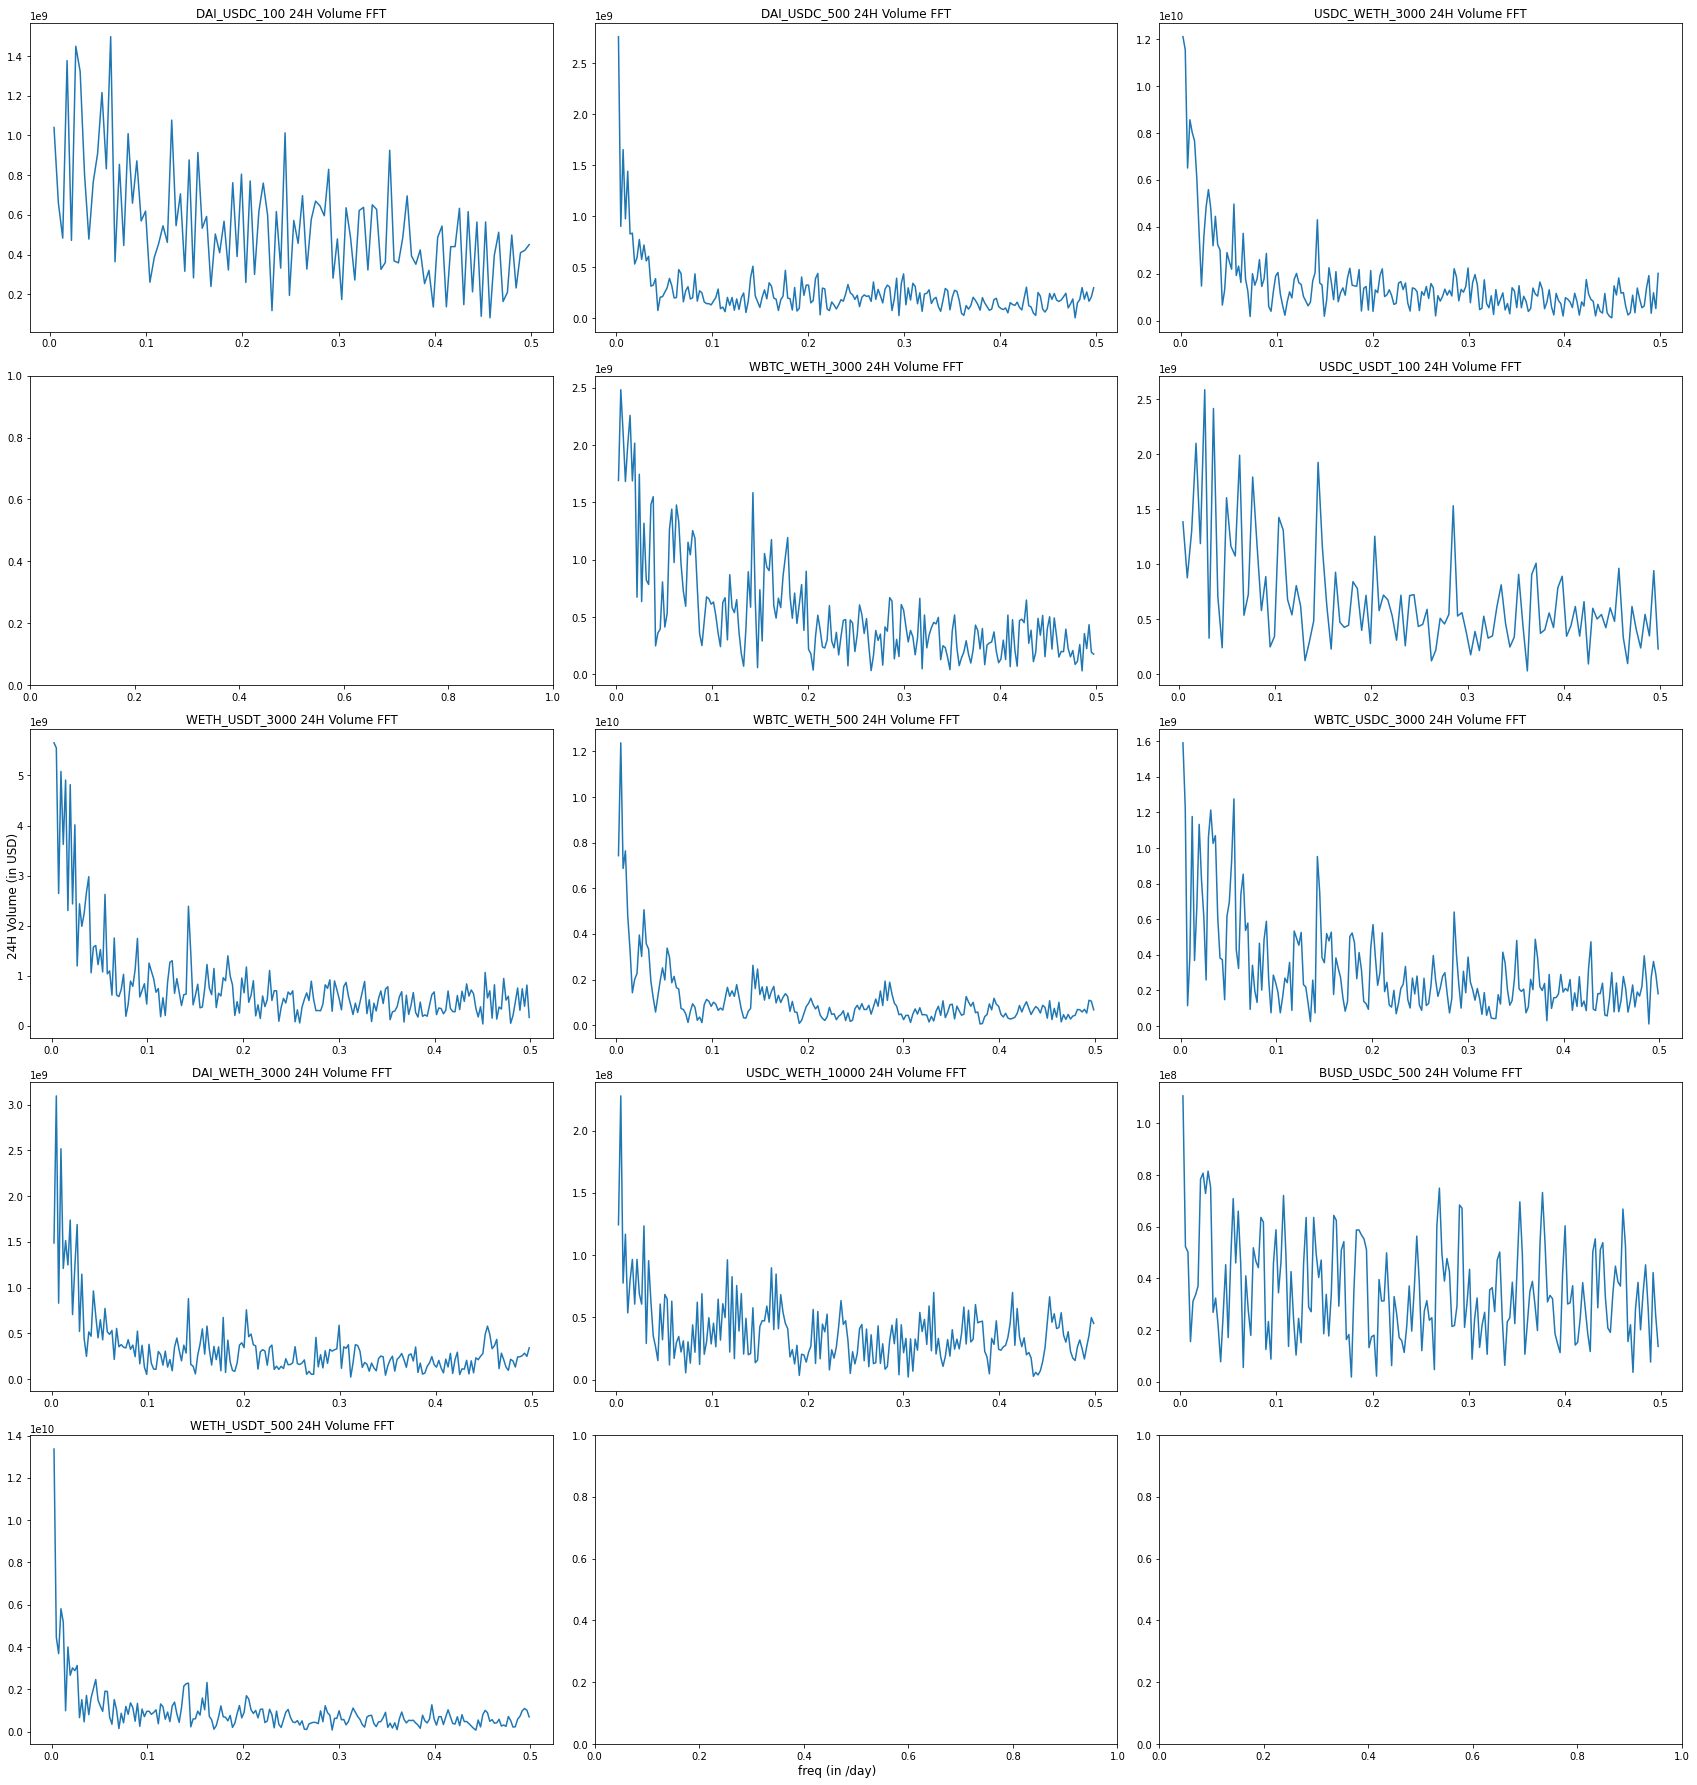

In [8]:
fig = plt.figure(figsize=(PLOT_WIDTH, SUBPLOT_HEIGHT * subplots_per_col))
axes = fig.subplots(subplots_per_col, SUBPLOTS_PER_ROW)

for i, pool_name in enumerate(pool_names):
    try:
        date_volume_df = pool_day_df[["date", pool_name + "_volumeUSD"]].dropna()
    except:
        continue
    volumeUSD_series = date_volume_df[pool_name + "_volumeUSD"]

    # reference for zero-mean signal:
    # https://dsp.stackexchange.com/questions/46950/removing-mean-from-signal-massively-distorts-fft
    # only keep those with freq STRICTLY > 0
    f_max = math.ceil(date_volume_df.shape[0] / 2)
    Y = abs(np.fft.fft(volumeUSD_series - volumeUSD_series.mean()))[1:f_max]
    freq = np.fft.fftfreq(date_volume_df.shape[0], 1)[1:f_max]

    ax = axes[math.floor(i / SUBPLOTS_PER_ROW), i % SUBPLOTS_PER_ROW]
    ax.title.set_text(f"{pool_name} 24H Volume FFT")
    ax.plot(freq, Y)

fig.supxlabel("freq (in /day)")
fig.supylabel("24H Volume (in USD)")
plt.tight_layout()
plt.show()

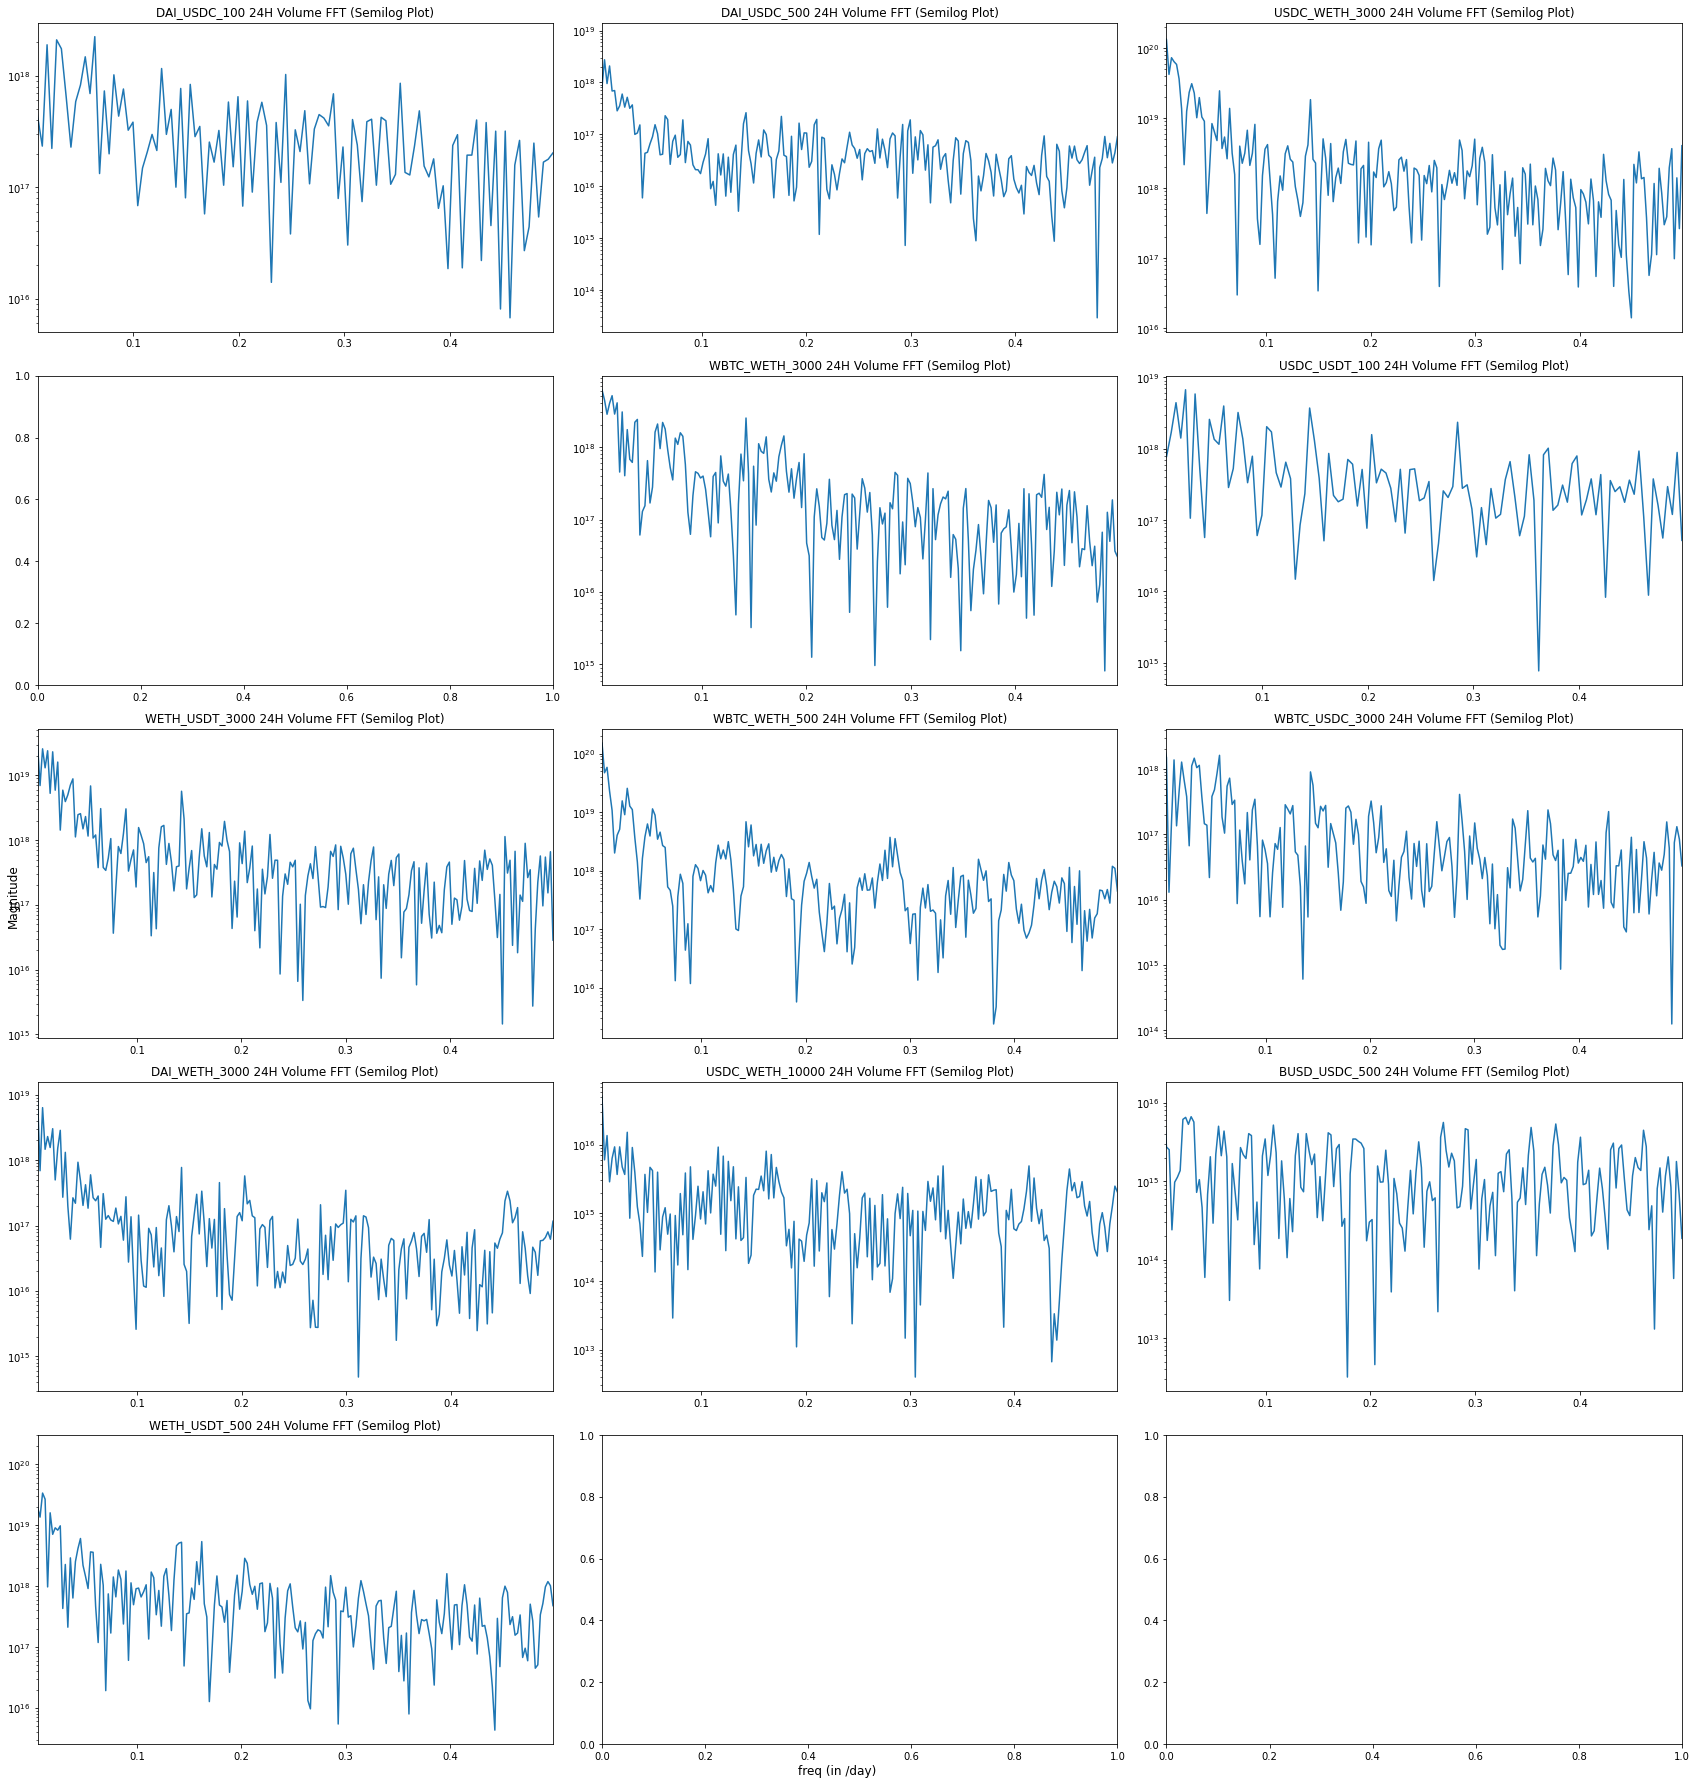

In [9]:
fig = plt.figure(figsize=(PLOT_WIDTH, SUBPLOT_HEIGHT * subplots_per_col))
axes = fig.subplots(subplots_per_col, SUBPLOTS_PER_ROW)

for i, pool_name in enumerate(pool_names):
    try:
        date_volume_df = pool_day_df[["date", pool_name + "_volumeUSD"]].dropna()
    except:
        continue
    volumeUSD_series = date_volume_df[pool_name + "_volumeUSD"]

    # reference for zero-mean signal:
    # https://dsp.stackexchange.com/questions/46950/removing-mean-from-signal-massively-distorts-fft
    # only keep those with freq STRICTLY > 0
    f_max = math.ceil(date_volume_df.shape[0] / 2)
    Y = abs(np.fft.fft(volumeUSD_series - volumeUSD_series.mean()))[1:f_max]
    freq = np.fft.fftfreq(date_volume_df.shape[0], 1)[1:f_max]

    # c.f. power spectral density in signal processing
    spectrum = Y.real * Y.real + Y.imag * Y.imag

    ax = axes[math.floor(i / SUBPLOTS_PER_ROW), i % SUBPLOTS_PER_ROW]
    ax.title.set_text(f"{pool_name} 24H Volume FFT (Semilog Plot)")
    ax.set_xlim(left=freq[1], right=freq[-1])

    # Note: this is possible because FFT must give positive values,
    # so that their logarithms always exist.
    # plot log10(spectrum) against frequency
    ax.semilogy(freq, spectrum)

fig.supxlabel("freq (in /day)")
fig.supylabel("Magnitude")
plt.tight_layout()
plt.show()